# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [69]:
import os
import requests
import re
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


## Introduction to Parsing Trees & Dataset

### Parsing Trees

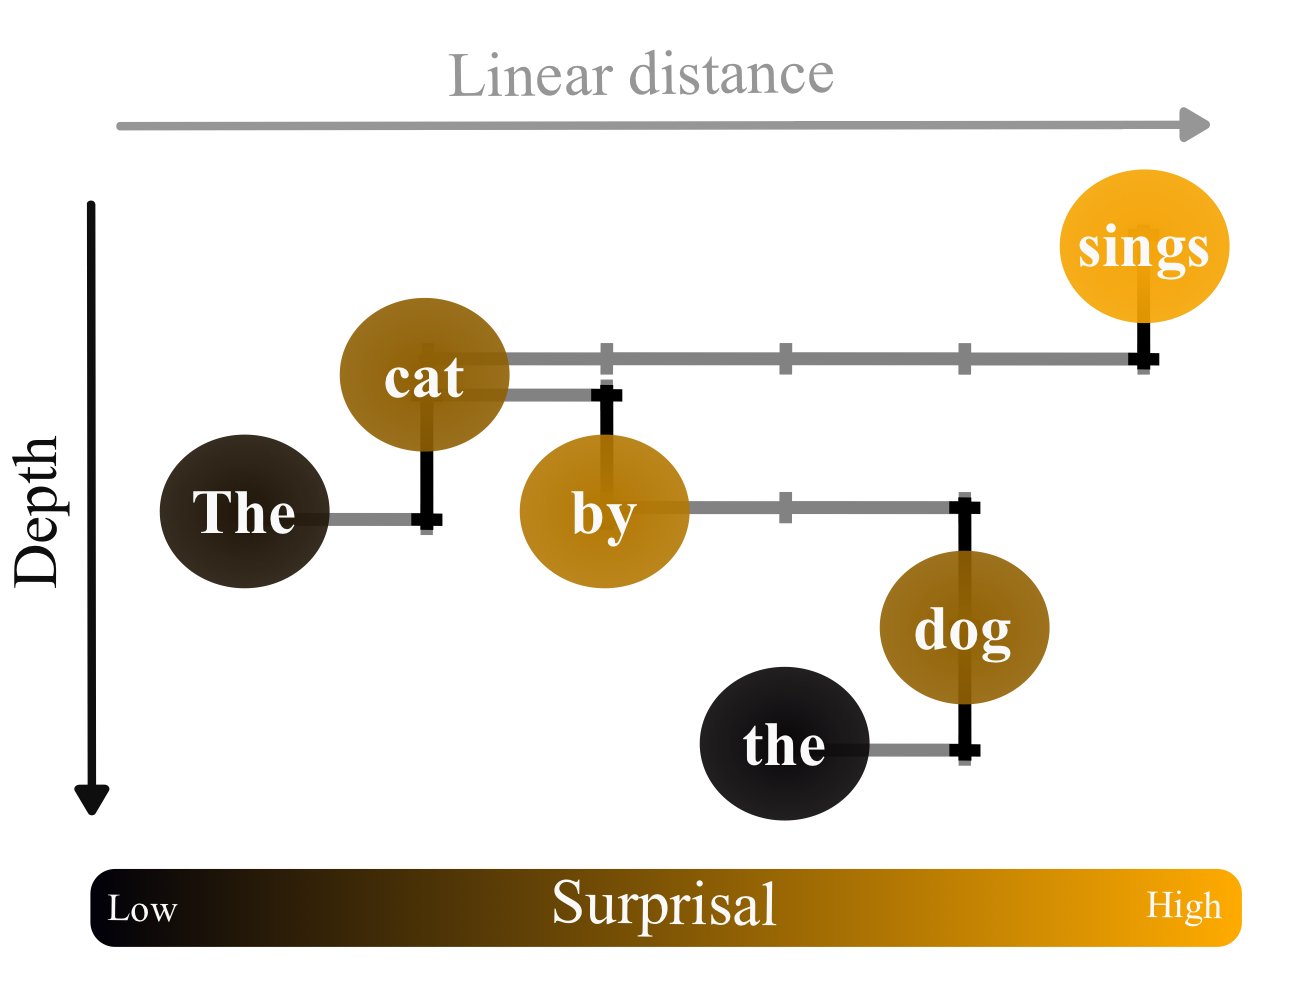

In [70]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adapted from Diego-Simon et al. (2025) depicts a typical **dependency-based parse** tree for a short sentence. Nodes in the tree represent words, and edges represent immediate dependencies. Nodes that connect to a lower-level node are referred to as that node’s **parent**, while the lower-level node is called the **child**. At the lowest depth, we find the **root** of the sentence (sings), which is the main verb of the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase “by the dog” modifies the subject “cat.”

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [71]:
def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

sentences_train, sentences_test = get_data()
print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12279 training sentences and 2004 test sentences.


Print some example sentences:

In [72]:
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentences_train[i].metadata["text"])

THIS STORY IS 100% TRUE.
the passcode: 6871082#
A few more years may pass before everybody acknowledges that it is a World War, but we are already well into it.
I could have stayed all day and not seen all the things.
Your comments to the transfer agreement were fine.


The dependency tree structure can be described by a single variable (head), specifying the **parent** of a given word.

In [73]:
idx = 59
print(sentences_test[idx].metadata["text"])
print("")
for tok in sentences_test[idx]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[idx][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

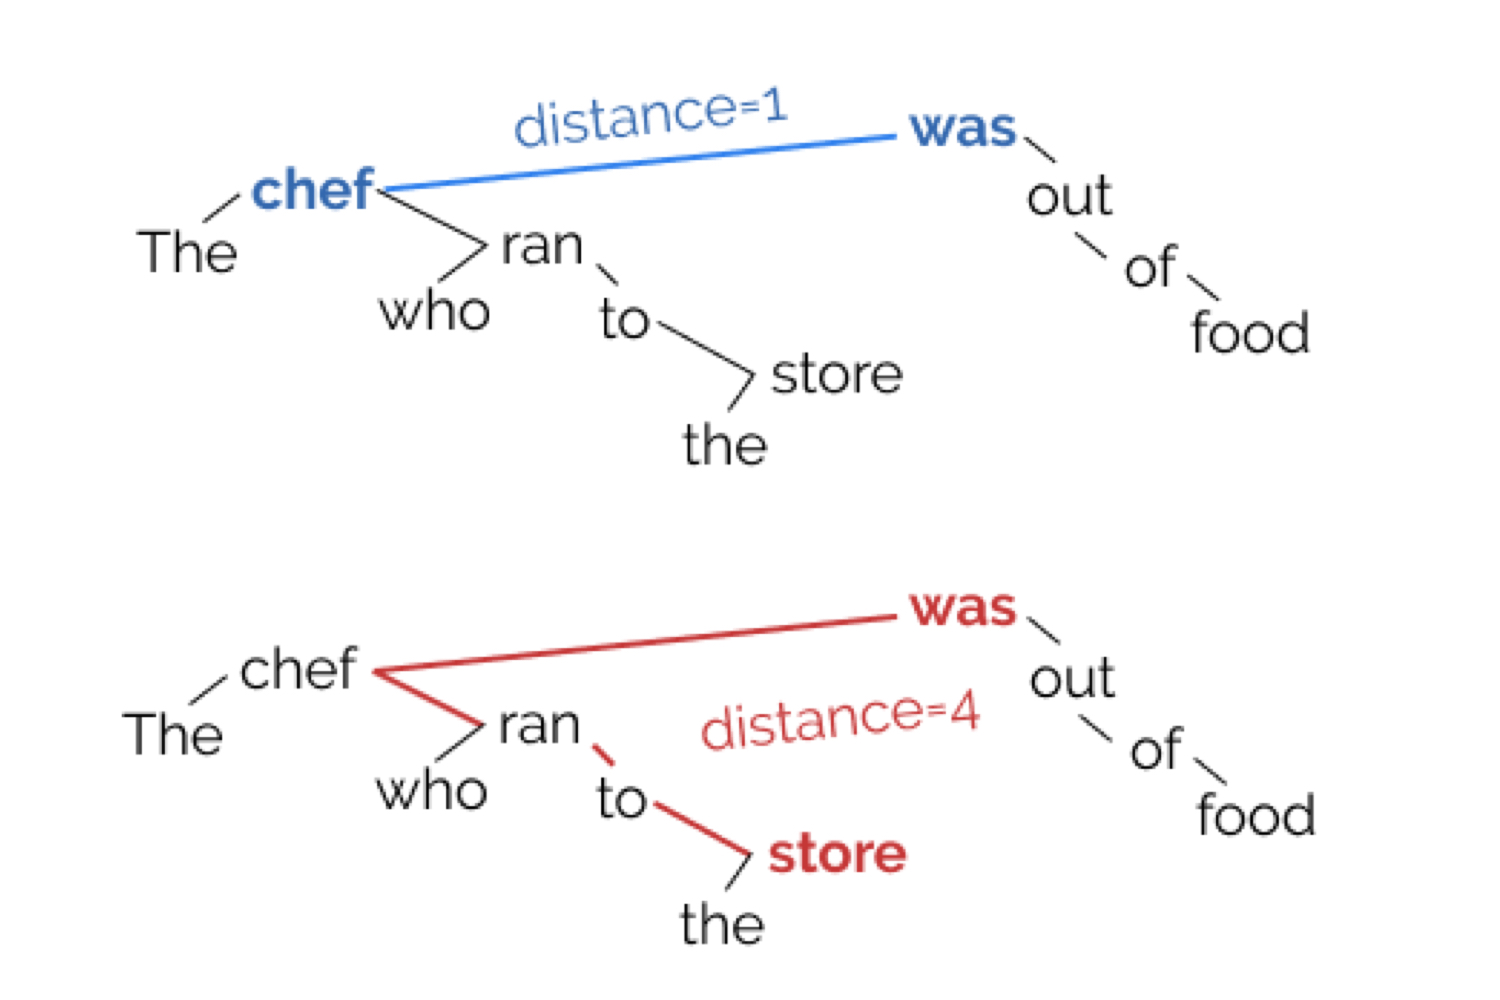

In [74]:
# example from Hewitt and Manning (2019)
image_path = "images/distance_scheme.jpeg"
display(Image(filename=image_path, width=400, height = 300))

### Define Functions

Below is a custom function to get syntactic tree distances from our annotated sentences

<Axes: >

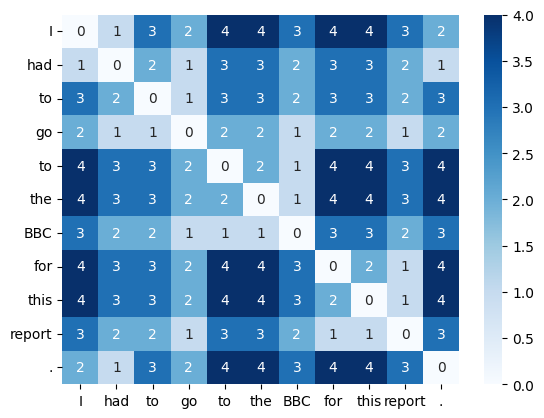

In [75]:
# expand to see function
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[idx])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transform the distance matrix into a dependency-based parse tree using the NetworkX library. We obtain the minimum spanning tree using Kruskal’s algorithm. Note that we manually set the node positions according to their order in the sentence (x-axis) and their distance from the root (i.e., depth; y-axis).

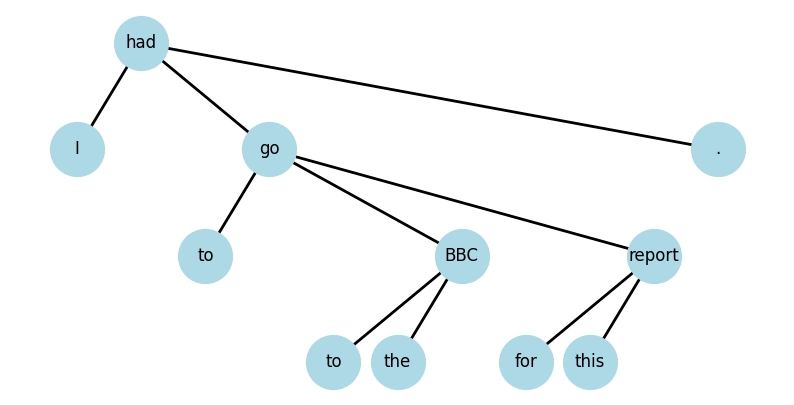

In [76]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2, plot = True):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix as np array
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist, to get a readable plot
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        nx.draw(
            mst,
            pos=pos,
            ax=ax,
            with_labels=True,
            labels={i: forms[i] for i in range(len(forms))},
            node_color='lightblue',
            edge_color='black',
            node_size=node_size,
            font_size=font_size,
            width=width,
        )
        ax.set_xlabel("ids")
        ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Lets do this for some more sentences:

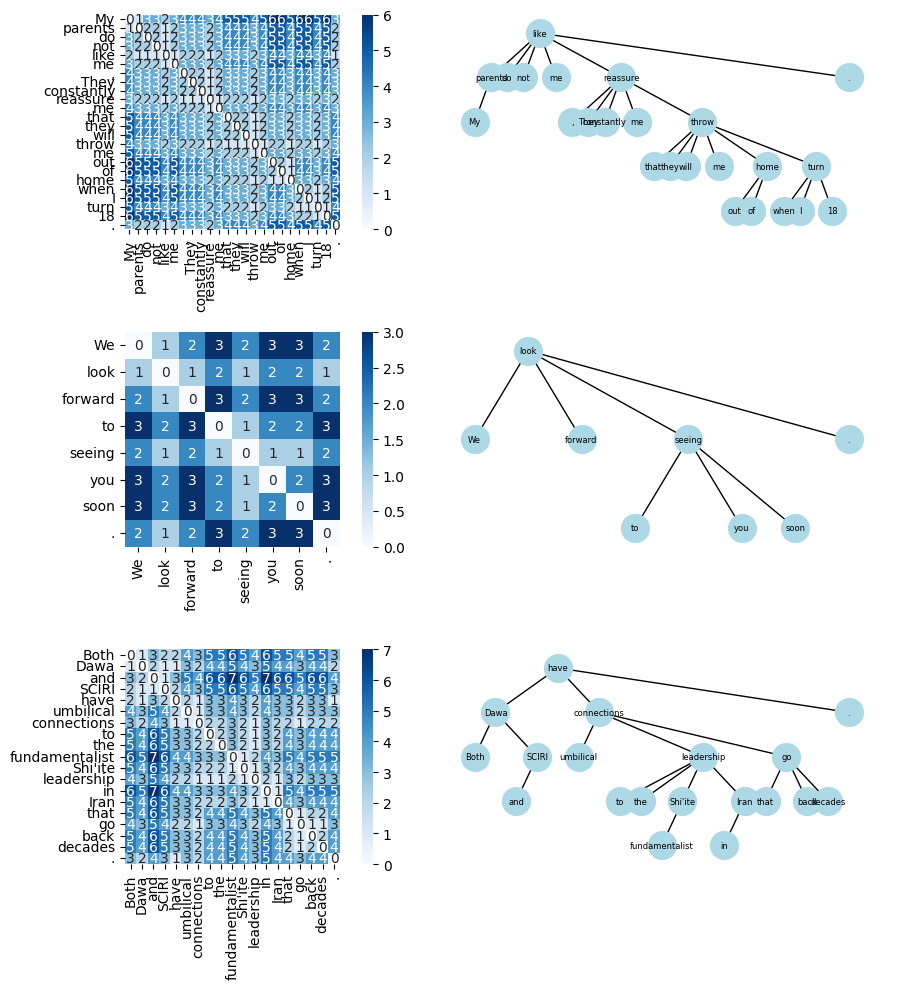

In [77]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(2) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

## Research Question

We evaluate whether parsing trees are embedded in the hidden layer of a large language model. However, se cannot decode the syntactic dependencies by looking at the raw embeddings, since these will also encode additional information, such as semantics or task relevant aspects for next-token prediction. Therefore, we will aim to extract the syntactic content using a **structural probe**, which maps the embeddings into a new, lower-dimensional structure (see figure below)

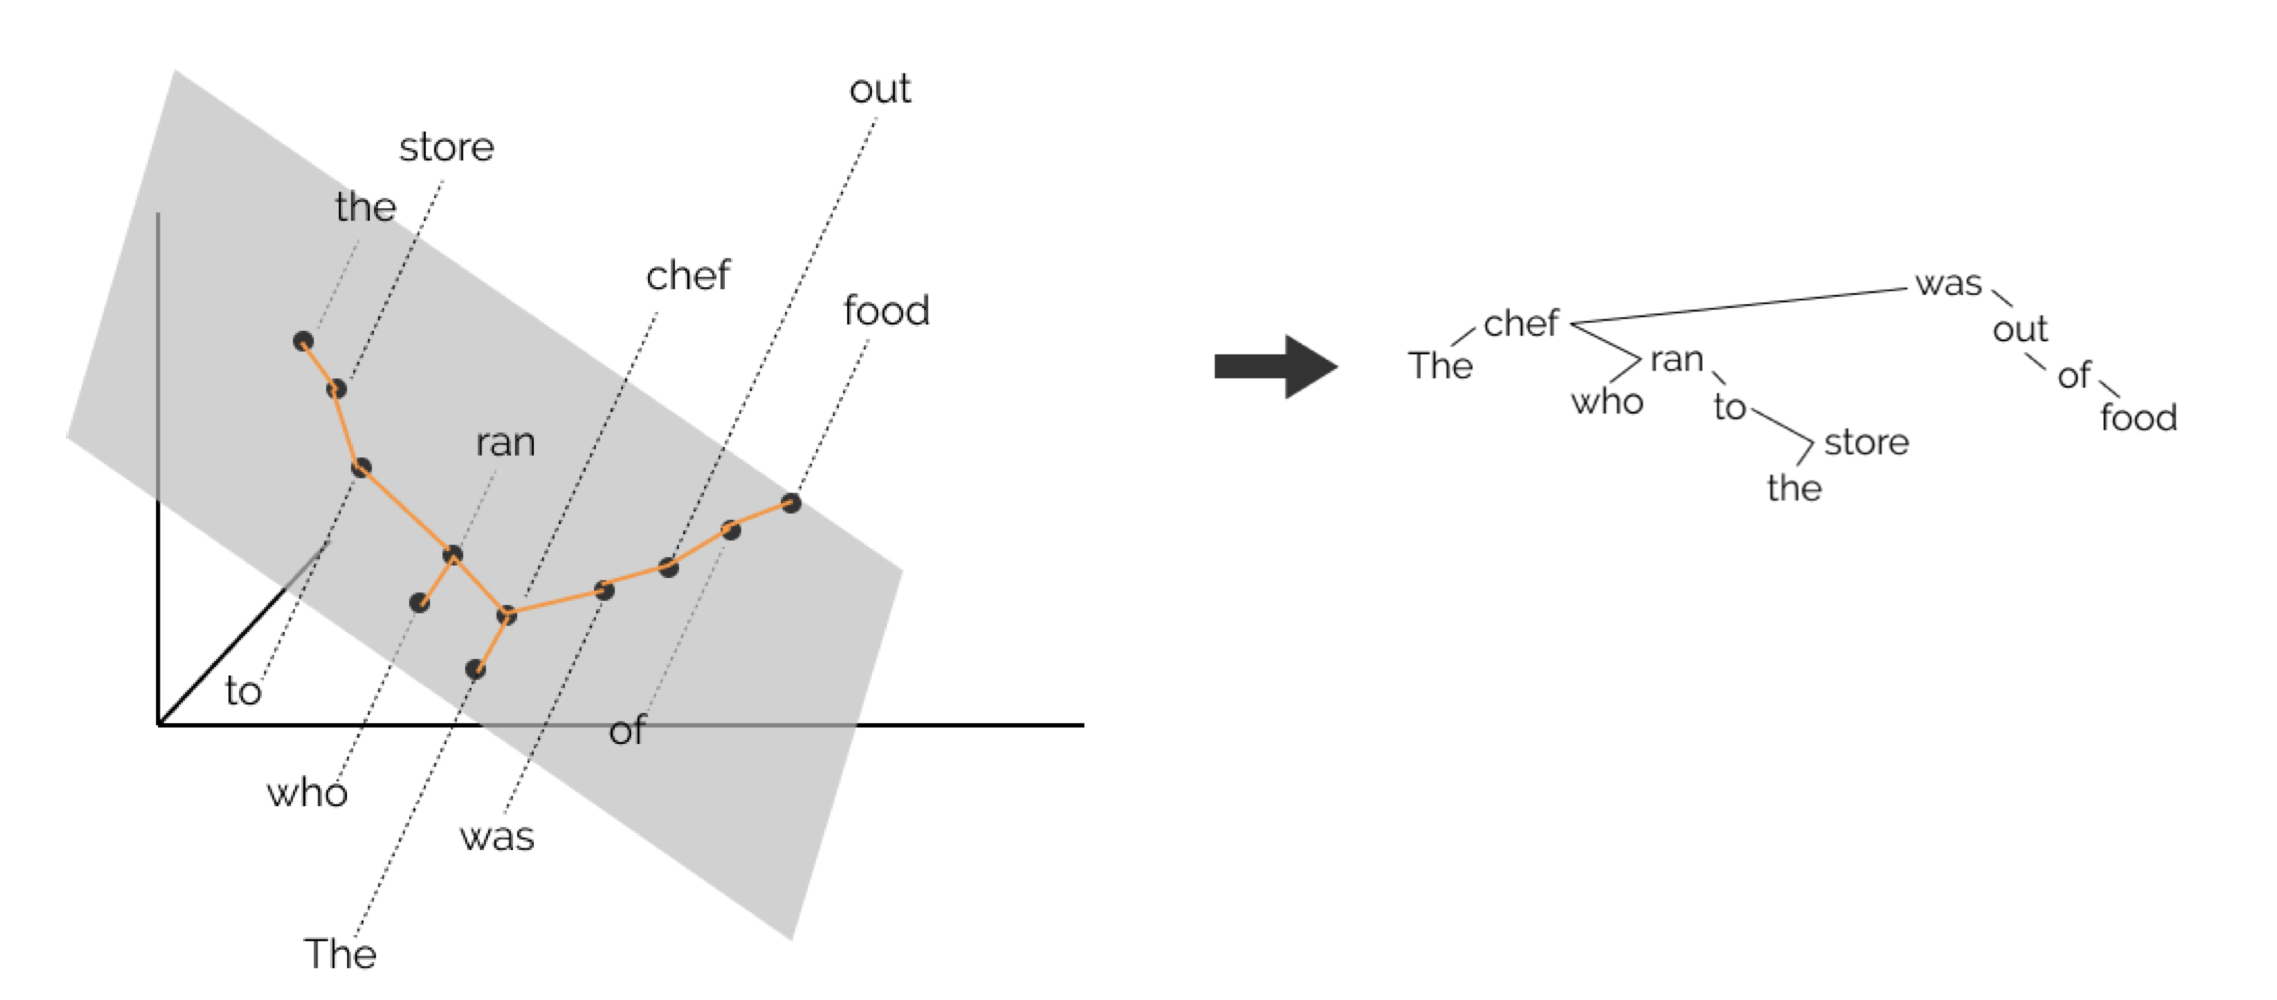

In [78]:
# from Hewitt and Manning (2019)
image_path = "images/probe_scheme.jpeg"
display(Image(filename=image_path, width=600, height=400))

The probe transforms the individual word embeddings (from the LLM) for each token in the sentence. Specifically, it projects each embedding into a lower-dimensional space (of a pre-determined size) using the learned probe matrix. Then, it computes pairwise distances between these projected embeddings to form the predicted syntactic distance matrix. Therefore, the only "deep" learning we do, is determining that projection matrices weights.

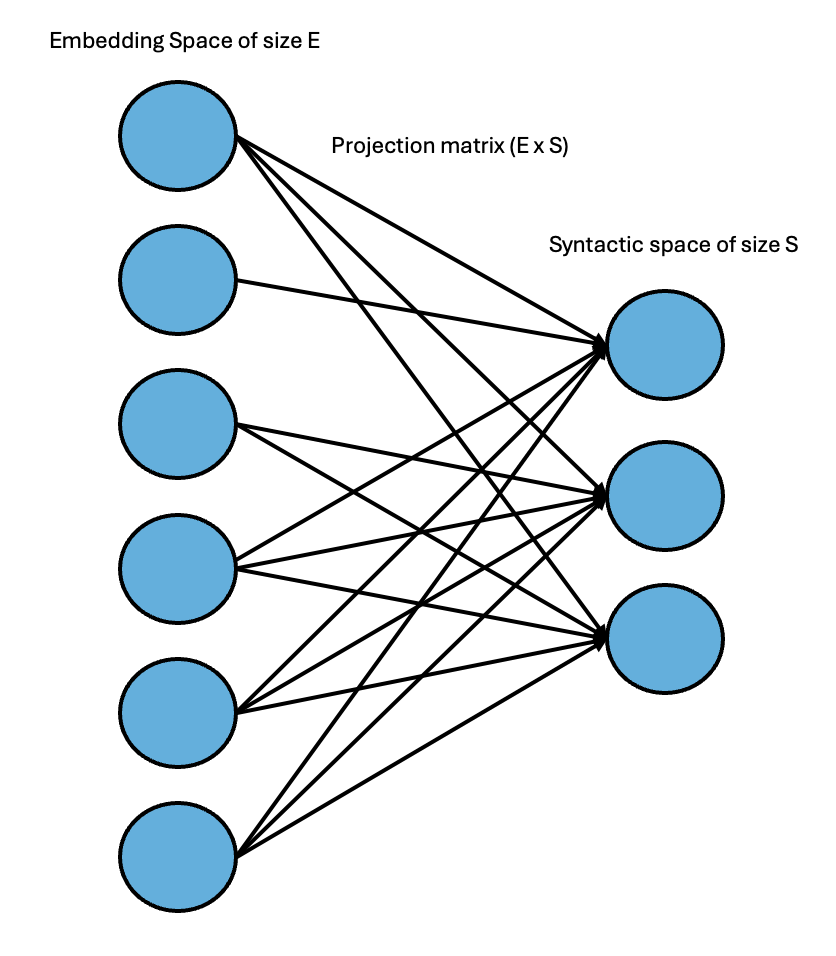

In [79]:
# add figure showing probe architecture
image_path = "images/mlp_scheme.png"
display(Image(filename=image_path, width=300, height=200))

Our projects unique contributions are...

## Implement Structural Probe

### Define functions to get embeddings and matrices

For the ground truth matrices, we just apply it to all our sentences in the for-loop. For the LLM-emeddings we need to ensure that the models tokenizer matches our annotations in the dataset. We do this by averaging embeddings of tokens that are part of the same word.

In [81]:
def get_matrices(sentences):
    """function to get distance matrices for a list of sentences"""
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices
matrices_train = get_matrices(sentences_train)

def combine_token_embeddings(text, word_list, model, layer_name):
    """
    Given a sentence string, a list of words (from UD), and a model,
    returns a tensor of shape (num_words, hidden_dim) where each row
    is the combined embedding for a word (by averaging over subword tokens).
    """
    # Tokenize with offsets
    tokenizer = model.tokenizer
    encoding = tokenizer(text, return_offsets_mapping=True, return_tensors='pt')
    offsets = encoding['offset_mapping'][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    # Get model activations
    _, cache = model.run_with_cache([text])
    activations = cache[layer_name][0]  # shape: (num_tokens, hidden_dim)
    # Map words to token indices
    word_spans = []
    start = 0
    for word in word_list:
        end = start + len(word)
        word_spans.append((start, end))
        start = end + 1  # +1 for space
    # For each word, find token indices whose offsets overlap with the word span
    word_embeddings = []
    for span in word_spans:
        indices = [i for i, (s, e) in enumerate(offsets) if not (e <= span[0] or s >= span[1])]
        if indices:
            emb = activations[indices].mean(dim=0)
        else:
            emb = torch.zeros(activations.shape[1], device=activations.device)
        word_embeddings.append(emb)
    return torch.stack(word_embeddings)

In [82]:
class SyntaxProbeDataset(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            activations = combine_token_embeddings(text, [tok["form"] for tok in sentence], model, layer_name)
            activation = activations.cpu().numpy()
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
                
            if activation.shape[0] > 0 and mat.shape[0] > 0:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]
    
def custom_collate_fn(batch):
    """Function to collate a batch of (activation, matrix) tuples by padding them to the same length."""
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None

### Load Data

In [83]:
sentences_train, sentences_test = get_data()
# create val split
np.random.seed(9)
val_idx = np.random.choice(len(sentences_train), size=int(0.1 * len(sentences_train)), replace=False)
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]

len(sentences_train), len(sentences_val), len(sentences_test)

(11052, 1227, 2004)

### Implement Probes and Regimen

The code for the probes is adpated from https://github.com/john-hewitt/structural-probes

In [84]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

In [85]:
class L1DistanceLoss(nn.Module):
  """Custom L1 loss for distance matrices."""
  def __init__(self, args):
    super(L1DistanceLoss, self).__init__()
    self.args = args
    self.word_pair_dims = (1,2)

  def forward(self, predictions, label_batch, length_batch):
    """ Computes L1 loss on distance matrices.

    Ignores all entries where label_batch=-1
    Normalizes first within sentences (by dividing by the square of the sentence length)
    and then across the batch.

    Args:
      predictions: A pytorch batch of predicted distances
      label_batch: A pytorch batch of true distances
      length_batch: A pytorch batch of sentence lengths

    Returns:
      A tuple of:
        batch_loss: average loss in the batch
        total_sents: number of sentences in the batch
    """
    device = predictions.device
    label_batch = label_batch.to(device)
    length_batch = length_batch.to(device)

    labels_1s = (label_batch != -1).float()
    predictions_masked = predictions * labels_1s
    labels_masked = label_batch * labels_1s
    total_sents = torch.sum((length_batch != 0)).float()
    squared_lengths = length_batch.pow(2).float()
    if total_sents > 0:
      loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=self.word_pair_dims)
      normalized_loss_per_sent = loss_per_sent / squared_lengths
      batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
    else:
      batch_loss = torch.tensor(0.0, device=self.args['device'])
    return batch_loss, total_sents


In [86]:
"""Classes for training and running inference on probes."""

class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

## Apply to layer

### Train Model

In [87]:
# this cell may take around 5-10 minutes to run, since all activations are being extracted and transformed to match data sequentially
# rank of probe and epoch was determined via validation set performance

layer = 'blocks.8.hook_resid_post'

args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
probe = TwoWordPSDProbe(args)
loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

# we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [07:40<00:00, 23.99it/s] 


Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 1227/1227 [00:40<00:00, 30.50it/s]


In [88]:
# model training may also take about 10 minutes
regimen.train_until_convergence(
    probe=probe,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

[training]:   5%|▌         | 1/20 [00:13<04:24, 13.90s/it]

[epoch 0] Train loss: 1229.2301917833736, Dev loss: 90.94780981783568
Saving probe parameters


[training]:  10%|█         | 2/20 [00:25<03:49, 12.74s/it]

[epoch 1] Train loss: 55.862142556653346, Dev loss: 32.988167113760376
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:38<03:34, 12.62s/it]

[epoch 2] Train loss: 21.21638262483291, Dev loss: 13.066198571289858
Saving probe parameters


[training]:  20%|██        | 4/20 [00:51<03:22, 12.66s/it]

[epoch 3] Train loss: 8.435666645172926, Dev loss: 4.98293326827891
Saving probe parameters


[training]:  25%|██▌       | 5/20 [01:04<03:16, 13.08s/it]

[epoch 4] Train loss: 3.3997301812021794, Dev loss: 2.007274319898237
Saving probe parameters


[training]:  30%|███       | 6/20 [01:17<03:02, 13.01s/it]

[epoch 5] Train loss: 1.6945125243821697, Dev loss: 1.2648082490655204
Saving probe parameters


[training]:  35%|███▌      | 7/20 [01:27<02:35, 11.99s/it]

[epoch 6] Train loss: 1.3909547923485353, Dev loss: 1.0725210060797383
Saving probe parameters


[training]:  40%|████      | 8/20 [01:37<02:16, 11.41s/it]

[epoch 7] Train loss: 1.334894666713172, Dev loss: 1.088009403698213


[training]:  45%|████▌     | 9/20 [01:47<02:01, 11.00s/it]

[epoch 8] Train loss: 0.8689196263367484, Dev loss: 0.91671771738912
Saving probe parameters


[training]:  50%|█████     | 10/20 [01:55<01:40, 10.05s/it]

[epoch 9] Train loss: 0.8521809860109377, Dev loss: 0.9197405121048583


[training]:  55%|█████▌    | 11/20 [02:12<01:49, 12.17s/it]

[epoch 10] Train loss: 0.8375906946000697, Dev loss: 0.9031894189512817
Saving probe parameters


[training]:  60%|██████    | 12/20 [02:43<02:23, 17.88s/it]

[epoch 11] Train loss: 0.8352748496006935, Dev loss: 0.9015500240434742
Saving probe parameters


[training]:  65%|██████▌   | 13/20 [03:03<02:08, 18.42s/it]

[epoch 12] Train loss: 0.8337292793735058, Dev loss: 0.9001518271274458
Saving probe parameters


[training]:  70%|███████   | 14/20 [03:23<01:54, 19.01s/it]

[epoch 13] Train loss: 0.832024054642911, Dev loss: 0.8988070810530957
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [03:47<01:42, 20.58s/it]

[epoch 14] Train loss: 0.8303621758424067, Dev loss: 0.8964169167267567
Saving probe parameters


[training]:  80%|████████  | 16/20 [04:08<01:22, 20.61s/it]

[epoch 15] Train loss: 0.8285402748578707, Dev loss: 0.8942474537781806
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [04:27<01:00, 20.11s/it]

[epoch 16] Train loss: 0.82659479720067, Dev loss: 0.8917730342302268
Saving probe parameters


[training]:  90%|█████████ | 18/20 [04:48<00:40, 20.29s/it]

[epoch 17] Train loss: 0.8236524839570373, Dev loss: 0.8897180767105961
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [05:09<00:20, 20.46s/it]

[epoch 18] Train loss: 0.8215825787239475, Dev loss: 0.8862198430926409
Saving probe parameters


[training]: 100%|██████████| 20/20 [05:28<00:00, 16.45s/it]

[epoch 19] Train loss: 0.8183185860940696, Dev loss: 0.8842722271745925
Saving probe parameters


### Loading a probe dict

In [132]:
matrix = torch.load('probe_params/blocks.8.hook_resid_post_probe_params.pt')

In [137]:
matrix['proj'].shape

torch.Size([768, 64])

In [140]:
# Set up args as in training
layer = 'blocks.8.hook_resid_post'
args = {
    'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer}_probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 20},
    'reporting': {'root': './'}
}
# Load probe and parameters
probe_test = TwoWordPSDProbe(args)
state_dict = torch.load(args['probe']['params_path'], map_location=args['device'])
probe_test.load_state_dict(state_dict)
probe_test.eval()

Constructing TwoWordPSDProbe


TwoWordPSDProbe()

In [ ]:

# Prepare your evaluation dataset and dataloader
novel_sentences = sentences_test  # or any list of sentences
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size=100, collate_fn=custom_collate_fn)

class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

# Use regimen's predict method
predictions = regimen.predict(probe_test, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:01<00:00, 19.31it/s]


In [143]:
eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=predictions, batch_size=100).mean()

sentence_length     12.183134
TP                   4.298403
TN                 106.203593
FP                   6.884731
FN                   6.884731
accuracy             0.741256
sensitivity          0.456321
specificity          0.718016
spearman_rho         0.386200
dtype: float64

## Model Evaluation

First, we take a look at the loss curves. Loss is decreasing over epochs which means that at least something is being learned successfully. Moreover, there os no evidence of overfitting.

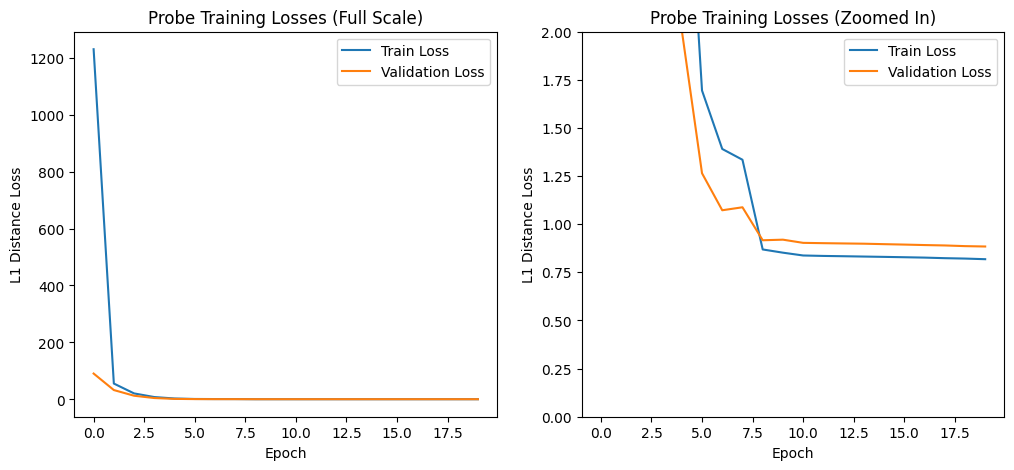

In [89]:
# loss function plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(regimen.train_losses, label='Train Loss')
ax[0].plot(regimen.val_losses, label='Validation Loss')
ax[0].set_title('Probe Training Losses (Full Scale)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('L1 Distance Loss')
ax[0].legend()

ax[1].plot(regimen.train_losses, label='Train Loss')
ax[1].plot(regimen.val_losses, label='Validation Loss')
ax[1].set_title('Probe Training Losses (Zoomed In)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('L1 Distance Loss')
ax[1].set_ylim(0, 2)
ax[1].legend()

Loss curves are nice, but not very interpretable. So next we apply our model on some previously unseen sentences (the test set)

In [91]:
# Prepare new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = sentences_test
novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer)
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


Bush did not have his eye on the ball.


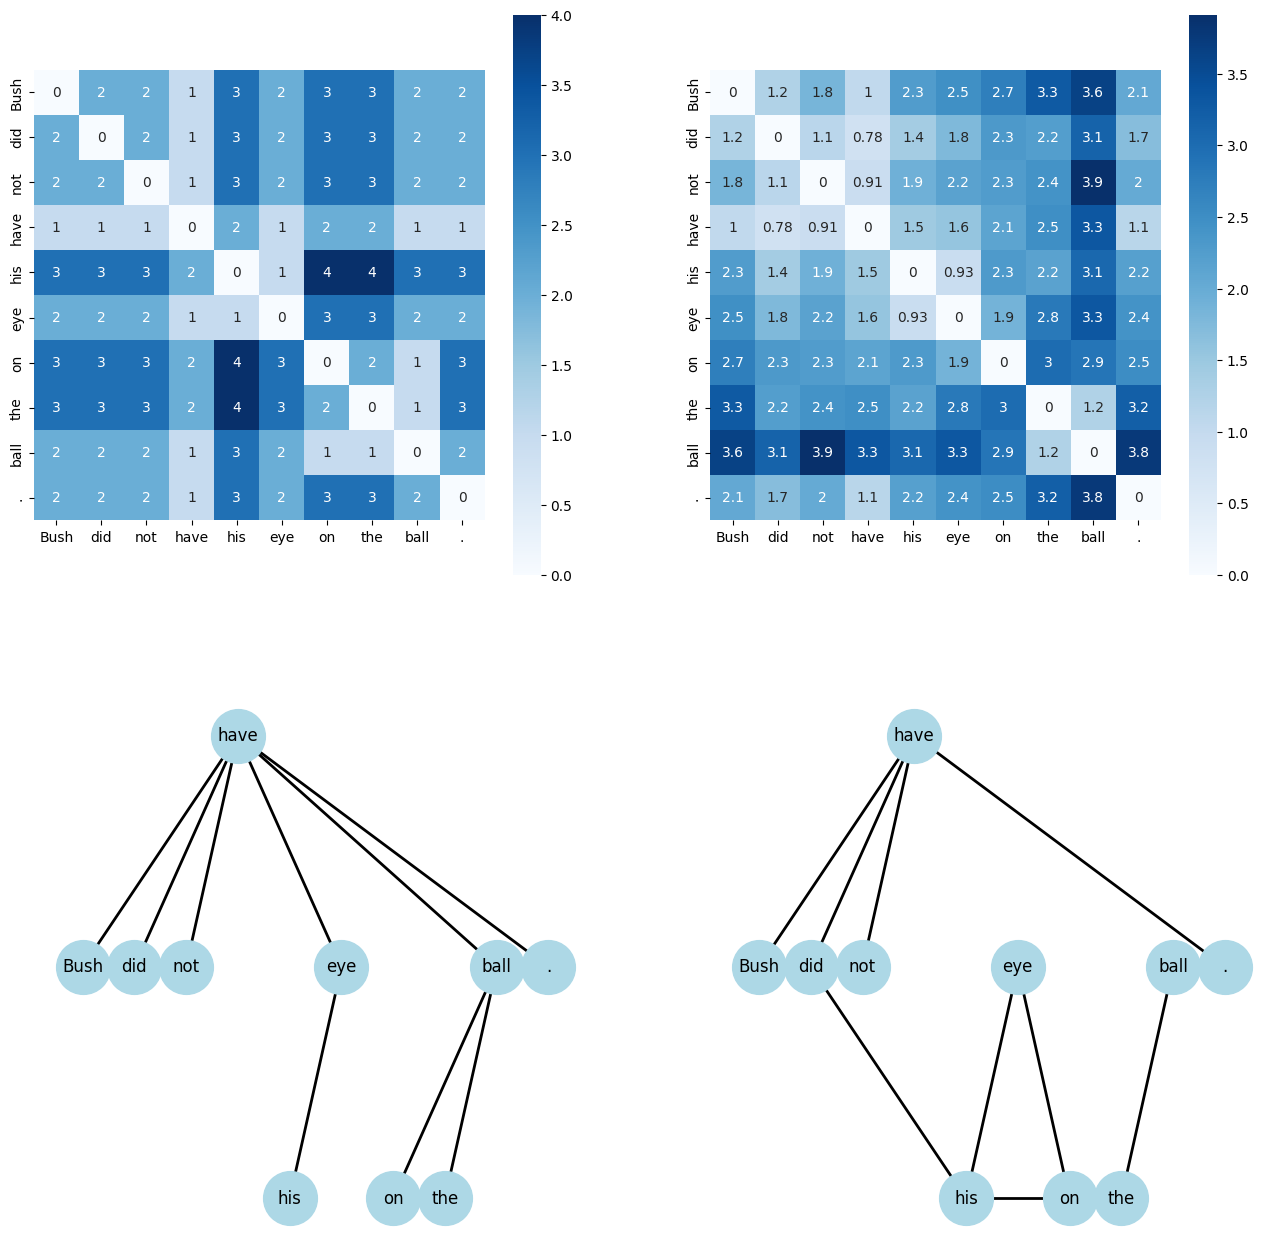

In [92]:
# plot an example of true vs.predicted sentence
sentence_idx = 192
batch_size = 100
batch_id = sentence_idx // batch_size
idx_in_batch = sentence_idx % batch_size

mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
# true mat
sns.heatmap(mat, cmap = "Blues", square = True, annot = True, xticklabels=forms, yticklabels=forms, ax = ax[0, 0])
# pred mat
sns.heatmap(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)],square=True,
            cmap = "Blues", annot = True, xticklabels=forms, yticklabels=forms, 
            ax = ax[0, 1])

graph_from_distance_matrix(mat, ids, root_dist, forms, ax=ax[1, 0])
graph_from_distance_matrix(predictions[batch_id][idx_in_batch][:len(sentence), :len(sentence)], ids, root_dist, forms, ax=ax[1, 1])

plt.show()

In [93]:
from scipy.stats import spearmanr
def eval_spearman(test_sentences, predictions, batch_size):
    rhos = []
    upper_pred_mats = []
    upper_mats = []
    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, _, _, _ = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]

        inds = np.triu_indices_from(mat, k=1)
        upper_mat = mat[inds]
        upper_pred_mat = pred_mat[inds]

        rho, _ = spearmanr(upper_mat, upper_pred_mat)
        rhos.append(rho)
        upper_pred_mats.append(upper_pred_mat)
        upper_mats.append(upper_mat)
    return rhos

In [102]:
from scipy.stats import spearmanr
def eval_parse_trees_by_sentence(test_sentences, predictions, batch_size):
    df = pd.DataFrame(columns=['sentence_length', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'sensitivity', 'specificity', 'spearman_rho'])
    for sentence_idx, sentence in enumerate(test_sentences):
        
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        # ensure square and same size
        pred_mat = pred_mat[:n, :n]
        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices_from(m1, k=1)
        upper_m1 = m1[inds]
        upper_m2 = m2[inds]

        TP = np.count_nonzero((upper_m1 != 0) & (upper_m2 != 0))
        TN = np.count_nonzero((upper_m1 == 0) & (upper_m2 == 0))
        FP = np.count_nonzero((upper_m1 == 0) & (upper_m2 != 0))
        FN = np.count_nonzero((upper_m1 != 0) & (upper_m2 == 0))
    
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # aka recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 

        inds = np.triu_indices_from(mat, k=1)
        upper_mat = mat[inds]
        upper_pred_mat = pred_mat[inds]

        rho, _ = spearmanr(upper_mat, upper_pred_mat)

        df.loc[sentence_idx] = [n,TP, TN, FP, FN, accuracy, sensitivity, specificity, rho]

    return df

In [ ]:
def eval_parse_trees_by_depth(test_sentences, predictions, batch_size):
    total_TP = total_TN = total_FP = total_FN = 0

    df = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])

    for sentence_idx, sentence in enumerate(test_sentences):
        batch_id = sentence_idx // batch_size
        idx_in_batch = sentence_idx % batch_size

        mat, ids, root_dist, forms = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        m1, _ = graph_from_distance_matrix(mat, ids, root_dist, forms, plot = False)

        pred_mat = predictions[batch_id][idx_in_batch]
        pred_mat = pred_mat[:n, :n]

        m2, _ = graph_from_distance_matrix(pred_mat, ids, root_dist, forms, plot = False)

        inds = np.triu_indices(n, k=1)
        for i, j in zip(inds[0], inds[1]):
            lin_dist = abs(i - j) if abs(i - j) < 10 else 10 # bin all values >= 10 together
            if lin_dist not in df.index:
                df.loc[lin_dist] = [0, 0, 0, 0]

            gold_edge = (m1[i, j] != 0)
            pred_edge = (m2[i, j] != 0)

            if gold_edge and pred_edge:
                total_TP += 1
                df.at[lin_dist, 'TP'] += 1
            elif (not gold_edge) and (not pred_edge):
                total_TN += 1
                df.at[lin_dist, 'TN'] += 1
            elif (not gold_edge) and pred_edge:
                total_FP += 1
                df.at[lin_dist, 'FP'] += 1
            elif gold_edge and (not pred_edge):
                total_FN += 1
                df.at[lin_dist, 'FN'] += 1

    # safe per-distance metrics
    df['accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
    df['sensitivity'] = np.where((df['TP'] + df['FN']) > 0, df['TP'] / (df['TP'] + df['FN']), 0)
    df['specificity'] = np.where((df['TN'] + df['FP']) > 0, df['TN'] / (df['TN'] + df['FP']), 0)
    df = df.fillna(0).sort_index()
    return df
            
# eval_df = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

In [ ]:
eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

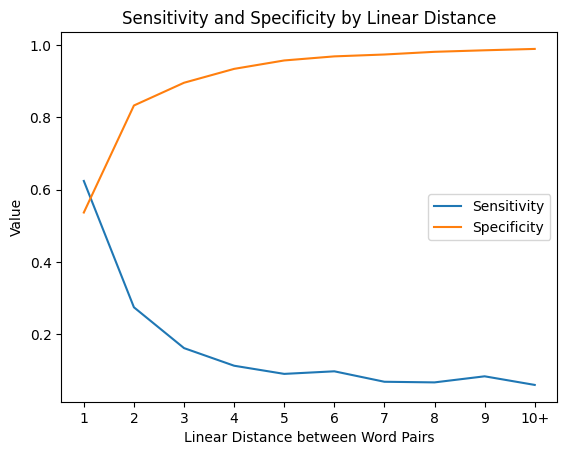

In [105]:
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["sensitivity"])
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["specificity"])
plt.xticks(np.arange(len(eval_df_depth)), labels= [str(i) for i in eval_df_depth.index][:len(eval_df_depth) - 1] + ["10+"])
plt.xlabel("Linear Distance between Word Pairs")
plt.ylabel("Value")
plt.title("Sensitivity and Specificity by Linear Distance")
plt.legend(["Sensitivity", "Specificity"])
plt.show()

In [106]:
eval_df_sentence = eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=predictions, batch_size=100)
eval_df_sentence

,sentence_length,TP,TN,FP,FN,accuracy,sensitivity,specificity,spearman_rho
0,7.0,3.0,12.0,3.0,3.0,0.714286,0.500000,0.800000,0.413916
1,23.0,6.0,215.0,16.0,16.0,0.873518,0.272727,0.930736,0.415029
2,9.0,3.0,23.0,5.0,5.0,0.722222,0.375000,0.821429,0.508168
3,25.0,9.0,261.0,15.0,15.0,0.900000,0.375000,0.945652,0.494724
4,31.0,6.0,411.0,24.0,24.0,0.896774,0.200000,0.944828,0.296939
...,...,...,...,...,...,...,...,...,...
1999,2.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,NaN
2000,3.0,2.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.866025
2001,10.0,4.0,31.0,5.0,5.0,0.777778,0.444444,0.861111,0.421063
2002,26.0,9.0,284.0,16.0,16.0,0.901538,0.360000,0.946667,0.465107


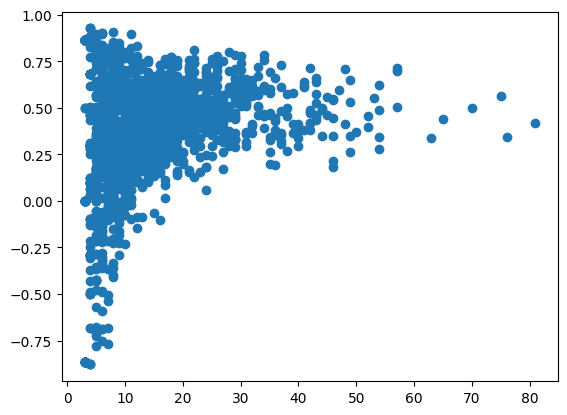

In [108]:
plt.plot(eval_df_sentence['sentence_length'], eval_df_sentence['spearman_rho'], 'o')

In [120]:
# generate linear baseline
def create_linear_baseline(test_sentences):
    baseline_matrices = []
    for sentence_idx, sentence in enumerate(test_sentences):

        mat, _, _, _ = distance_matrix_from_sentence(sentence)
        n = mat.shape[0]
        baseline_mat = np.zeros((n, n), dtype=int)
        for i in range(n):
            for j in range(n):
                baseline_mat[i, j] = abs(i - j)
        baseline_matrices.append(baseline_mat)
    return baseline_matrices

In [123]:
dummies = [[mat] for mat in create_linear_baseline(novel_sentences)]
dummy_df = eval_parse_trees_by_sentence(test_sentences=novel_sentences, predictions=dummies, batch_size=1)


In [127]:
print(dummy_df.mean())
print("----")
print(eval_df_sentence.mean())

sentence_length     12.183134
TP                   4.513473
TN                 106.418663
FP                   6.669661
FN                   6.669661
accuracy             0.744092
sensitivity          0.462561
specificity          0.723478
spearman_rho         0.364209
dtype: float64
----
sentence_length     12.183134
TP                   4.298403
TN                 106.203593
FP                   6.884731
FN                   6.884731
accuracy             0.741256
sensitivity          0.456321
specificity          0.718016
spearman_rho         0.386200
dtype: float64


In [128]:
df1 = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=dummies, batch_size=1)
eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)

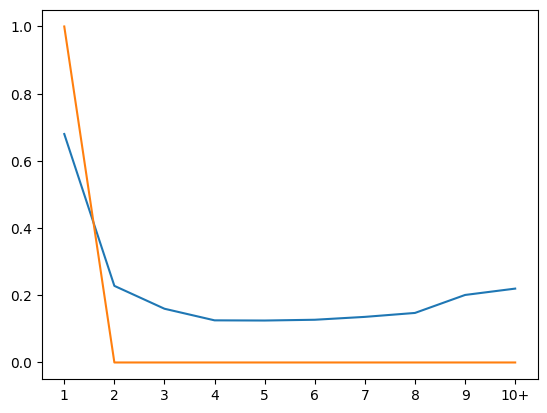

In [130]:
plt.plot(np.arange(len(eval_df_depth)), eval_df_depth["sensitivity"])
plt.plot(np.arange(len(df1)), df1["sensitivity"])
plt.xticks(np.arange(len(eval_df_depth)), labels= [str(i) for i in eval_df_depth.index][:len(eval_df_depth) - 1] + ["10+"])
plt.show()

## Scale up to multiple layers

In [144]:
sentences_train, sentences_test = get_data()
# create val split
np.random.seed(9)
val_idx = np.random.choice(len(sentences_train), size=int(0.1 * len(sentences_train)), replace=False)
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]
len(sentences_train), len(sentences_val), len(sentences_test)

(11052, 1227, 2004)

In [148]:
mod = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")
logits, cache = mod.run_with_cache(["The quick brown fox jumps over the lazy dog."])

Loaded pretrained model gpt2-small into HookedTransformer


In [150]:
cache.keys()


dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

In [ ]:
df_acc = pd.DataFrame(columns=['layer_name', 'train_loss', 'val_loss', 'eval_df_depth', 'eval_df_sentence'])
layer_names = ['blocks.0.hook_resid_pre',
               'blocks.0.hook_resid_post', 
               'blocks.2.hook_resid_post', 
               'blocks.4.hook_resid_post',
               'blocks.6.hook_resid_post',
               'blocks.10.hook_resid_post',
               'blocks.11.hook_resid_post']
for layer_name in layer_names:
    print(f"Processing layer: {layer_name}")
        
    args = {
        'probe': {'maximum_rank': 64, 'params_path': f'probe_params/{layer_name}_probe_params.pt'},
        'model': {'hidden_dim': 768},
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'probe_training': {'epochs': 20},
        'reporting': {'root': './'}
    }
    probe = TwoWordPSDProbe(args)
    loss_fn = L1DistanceLoss(args)
    regimen = ProbeRegimen(args)

    dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', layer_name)
    dataloader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn)

    val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', layer_name)
    val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)

    # we use this as the original code assumes feature extraction inside the regimen, while we do so with our custom functions in advance
    class IdentityModel(nn.Module):
        def forward(self, x):
            return x
    model = IdentityModel()

    regimen.train_until_convergence(
        probe=probe,
        model=model,
        loss=loss_fn,
        train_dataset=dataloader,
        dev_dataset=val_dataloader
    )
    
    # Make predictions
    # Prepare new sentences as a SyntaxProbeDataset and DataLoader
    novel_sentences = sentences_test
    novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', layer_name)
    novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

    # Make predictions
    predictions = regimen.predict(probe, model, novel_dataloader)

    eval_df_depth = eval_parse_trees_by_depth(test_sentences=novel_sentences, predictions=predictions, batch_size=100)
    eval_df_sentence = eval_parse_trees_by_sentence(novel_sentences, predictions, batch_size=100)
    df_acc.loc[len(df_acc)] = [layer_name, regimen.train_losses, regimen.val_losses, eval_df_depth, eval_df_sentence]
    pd.to_pickle(df_acc, f'df_acc.pkl')


Processing layer: blocks.0.hook_resid_pre
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [07:16<00:00, 25.34it/s]


Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:15<04:59, 15.75s/it]

[epoch 0] Train loss: 0.9406360245855485, Dev loss: 0.8733725007608254
Saving probe parameters


[training]:  10%|█         | 2/20 [00:30<04:30, 15.02s/it]

[epoch 1] Train loss: 0.8444297997967902, Dev loss: 0.8697432554535683
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:44<04:08, 14.61s/it]

[epoch 2] Train loss: 0.8233277555224777, Dev loss: 0.845584834408935
Saving probe parameters


[training]:  20%|██        | 4/20 [00:58<03:47, 14.23s/it]

[epoch 3] Train loss: 0.8128583350131532, Dev loss: 0.8516842298810814


[training]:  25%|██▌       | 5/20 [01:12<03:32, 14.19s/it]

[epoch 4] Train loss: 0.7891178200135316, Dev loss: 0.8350551002085841
Saving probe parameters


[training]:  30%|███       | 6/20 [01:26<03:18, 14.19s/it]

[epoch 5] Train loss: 0.7845872144875128, Dev loss: 0.8336618574246606
Saving probe parameters


[training]:  35%|███▌      | 7/20 [01:39<03:02, 14.00s/it]

[epoch 6] Train loss: 0.7824298056665642, Dev loss: 0.8325459558786953
Saving probe parameters


[training]:  40%|████      | 8/20 [01:52<02:43, 13.65s/it]

[epoch 7] Train loss: 0.7806314382266618, Dev loss: 0.8327895850793268


[training]:  45%|████▌     | 9/20 [02:05<02:28, 13.48s/it]

[epoch 8] Train loss: 0.7824533214355093, Dev loss: 0.8316633796536447
Saving probe parameters


[training]:  50%|█████     | 10/20 [02:18<02:13, 13.33s/it]

[epoch 9] Train loss: 0.781656777043296, Dev loss: 0.8311673252195872
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [02:33<02:02, 13.58s/it]

[epoch 10] Train loss: 0.7810414550186195, Dev loss: 0.8309893643069093
Saving probe parameters


[training]:  60%|██████    | 12/20 [02:49<01:55, 14.41s/it]

[epoch 11] Train loss: 0.7806069453988781, Dev loss: 0.8308258445260965
Saving probe parameters


[training]:  65%|██████▌   | 13/20 [03:01<01:35, 13.67s/it]

[epoch 12] Train loss: 0.7802234658977496, Dev loss: 0.8307492047086807


[training]:  70%|███████   | 14/20 [03:13<01:20, 13.35s/it]

[epoch 13] Train loss: 0.7802054036410011, Dev loss: 0.8300668192570445
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [03:22<00:59, 11.88s/it]

[epoch 14] Train loss: 0.779861377884502, Dev loss: 0.8298770085329337
Saving probe parameters


[training]:  80%|████████  | 16/20 [03:28<00:40, 10.05s/it]

[epoch 15] Train loss: 0.7797374573471837, Dev loss: 0.8297669924461657
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [03:33<00:26,  8.70s/it]

[epoch 16] Train loss: 0.7796732225670057, Dev loss: 0.8296916039862473


[training]:  90%|█████████ | 18/20 [03:39<00:15,  7.78s/it]

[epoch 17] Train loss: 0.7795552665497831, Dev loss: 0.829680878842081


[training]:  95%|█████████▌| 19/20 [03:45<00:07,  7.22s/it]

[epoch 18] Train loss: 0.7795458596726927, Dev loss: 0.8296712192948893


[training]: 100%|██████████| 20/20 [03:51<00:00, 11.56s/it]


[epoch 19] Train loss: 0.7795293878223255, Dev loss: 0.8296701878965047
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:01<00:00, 19.84it/s]


Processing layer: blocks.0.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [08:05<00:00, 22.75it/s] 


Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:05<01:53,  5.95s/it]

[epoch 0] Train loss: 7.038723992904459, Dev loss: 1.0297821576554502
Saving probe parameters


[training]:  10%|█         | 2/20 [00:11<01:45,  5.86s/it]

[epoch 1] Train loss: 0.928855904883938, Dev loss: 0.8901567995402516
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:17<01:40,  5.91s/it]

[epoch 2] Train loss: 0.877420150409606, Dev loss: 0.8782762233668843
Saving probe parameters


[training]:  20%|██        | 4/20 [00:25<01:44,  6.54s/it]

[epoch 3] Train loss: 0.8754035131335043, Dev loss: 0.889883700481934


[training]:  25%|██▌       | 5/20 [00:38<02:13,  8.89s/it]

[epoch 4] Train loss: 0.7903748623409265, Dev loss: 0.8235949117571917
Saving probe parameters


[training]:  30%|███       | 6/20 [00:52<02:30, 10.75s/it]

[epoch 5] Train loss: 0.7716878288861336, Dev loss: 0.8200591335281086
Saving probe parameters


[training]:  35%|███▌      | 7/20 [01:06<02:33, 11.83s/it]

[epoch 6] Train loss: 0.7655209726153445, Dev loss: 0.8195004622530141
Saving probe parameters


[training]:  40%|████      | 8/20 [01:19<02:25, 12.10s/it]

[epoch 7] Train loss: 0.7624357864988743, Dev loss: 0.8168842188206357
Saving probe parameters


[training]:  45%|████▌     | 9/20 [01:32<02:18, 12.58s/it]

[epoch 8] Train loss: 0.76154455463825, Dev loss: 0.8173908507231298


[training]:  50%|█████     | 10/20 [01:46<02:07, 12.77s/it]

[epoch 9] Train loss: 0.7478189364836089, Dev loss: 0.8114988152924455
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [02:00<01:58, 13.21s/it]

[epoch 10] Train loss: 0.7440182381766972, Dev loss: 0.8103956550529747
Saving probe parameters


[training]:  60%|██████    | 12/20 [02:13<01:44, 13.12s/it]

[epoch 11] Train loss: 0.7423879548858742, Dev loss: 0.8103429627982017


[training]:  65%|██████▌   | 13/20 [02:26<01:32, 13.23s/it]

[epoch 12] Train loss: 0.7442729341953593, Dev loss: 0.8098357526286404
Saving probe parameters


[training]:  70%|███████   | 14/20 [02:40<01:19, 13.33s/it]

[epoch 13] Train loss: 0.7434447342357987, Dev loss: 0.8094396334697098
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [02:55<01:08, 13.72s/it]

[epoch 14] Train loss: 0.7428589925099834, Dev loss: 0.8092458735856956
Saving probe parameters


[training]:  80%|████████  | 16/20 [03:09<00:55, 13.82s/it]

[epoch 15] Train loss: 0.7423938815247697, Dev loss: 0.8091310378294605
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [03:22<00:41, 13.69s/it]

[epoch 16] Train loss: 0.7420322578366666, Dev loss: 0.8090107644974165
Saving probe parameters


[training]:  90%|█████████ | 18/20 [03:34<00:26, 13.29s/it]

[epoch 17] Train loss: 0.7418653250517209, Dev loss: 0.8088834773454612
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [03:48<00:13, 13.30s/it]

[epoch 18] Train loss: 0.741680851976724, Dev loss: 0.8088093550106132


[training]: 100%|██████████| 20/20 [04:02<00:00, 12.12s/it]


[epoch 19] Train loss: 0.7417849610777726, Dev loss: 0.8081758789833523
Saving probe parameters
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:02<00:00,  8.56it/s]


Processing layer: blocks.2.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [07:23<00:00, 24.90it/s]


Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:13<04:12, 13.26s/it]

[epoch 0] Train loss: 678.6045904584091, Dev loss: 32.344354805173
Saving probe parameters


[training]:  10%|█         | 2/20 [00:26<03:56, 13.16s/it]

[epoch 1] Train loss: 22.54493539142643, Dev loss: 15.662807847002025
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:40<03:51, 13.61s/it]

[epoch 2] Train loss: 11.399307424936698, Dev loss: 8.263321955027187
Saving probe parameters


[training]:  20%|██        | 4/20 [00:51<03:23, 12.72s/it]

[epoch 3] Train loss: 6.221360237323155, Dev loss: 4.623981450958376
Saving probe parameters


[training]:  25%|██▌       | 5/20 [00:56<02:28,  9.89s/it]

[epoch 4] Train loss: 3.661022102060501, Dev loss: 2.815983406197471
Saving probe parameters


[training]:  30%|███       | 6/20 [00:59<01:42,  7.32s/it]

[epoch 5] Train loss: 2.499403856044829, Dev loss: 1.9442624882555823
Saving probe parameters


[training]:  35%|███▌      | 7/20 [01:01<01:13,  5.67s/it]

[epoch 6] Train loss: 1.7763014628409994, Dev loss: 1.4713600830227356
Saving probe parameters


[training]:  40%|████      | 8/20 [01:03<00:53,  4.49s/it]

[epoch 7] Train loss: 1.4140907828461808, Dev loss: 1.2321825050783042
Saving probe parameters


[training]:  45%|████▌     | 9/20 [01:06<00:43,  3.99s/it]

[epoch 8] Train loss: 1.2177603576134135, Dev loss: 1.1016802302005335
Saving probe parameters


[training]:  50%|█████     | 10/20 [01:08<00:33,  3.39s/it]

[epoch 9] Train loss: 1.465179113473661, Dev loss: 0.9920872157438071
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [01:10<00:26,  2.99s/it]

[epoch 10] Train loss: 1.19273484741222, Dev loss: 0.9265016285306376
Saving probe parameters


[training]:  60%|██████    | 12/20 [01:12<00:21,  2.73s/it]

[epoch 11] Train loss: 1.4360916410025764, Dev loss: 0.9504826801427516


[training]:  65%|██████▌   | 13/20 [01:14<00:17,  2.50s/it]

[epoch 12] Train loss: 0.8263631647063734, Dev loss: 0.8750703091920636
Saving probe parameters


[training]:  70%|███████   | 14/20 [01:16<00:14,  2.36s/it]

[epoch 13] Train loss: 0.8189764248043396, Dev loss: 0.874780119388397
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [01:19<00:12,  2.42s/it]

[epoch 14] Train loss: 0.8140912878310556, Dev loss: 0.8823857490085643


[training]:  80%|████████  | 16/20 [01:20<00:09,  2.29s/it]

[epoch 15] Train loss: 0.8020659848653964, Dev loss: 0.859144314965681
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [01:23<00:07,  2.44s/it]

[epoch 16] Train loss: 0.8009675864158572, Dev loss: 0.8582887610674099
Saving probe parameters


[training]:  90%|█████████ | 18/20 [01:25<00:04,  2.33s/it]

[epoch 17] Train loss: 0.7999549041482965, Dev loss: 0.8577173150644715
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [01:27<00:02,  2.20s/it]

[epoch 18] Train loss: 0.7992717681309041, Dev loss: 0.8569393336724341
Saving probe parameters


[training]: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


[epoch 19] Train loss: 0.7986276801237367, Dev loss: 0.8562129416306425
Saving probe parameters
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 89.15it/s]


Processing layer: blocks.4.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [05:06<00:00, 36.05it/s]


Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:06<02:01,  6.42s/it]

[epoch 0] Train loss: 918.8840056235402, Dev loss: 50.95765334100576
Saving probe parameters


[training]:  10%|█         | 2/20 [00:12<01:53,  6.33s/it]

[epoch 1] Train loss: 34.93141494900085, Dev loss: 23.92847885965038
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:18<01:45,  6.21s/it]

[epoch 2] Train loss: 17.045861555880236, Dev loss: 12.057750798282141
Saving probe parameters


[training]:  20%|██        | 4/20 [00:24<01:39,  6.20s/it]

[epoch 3] Train loss: 8.76492561674446, Dev loss: 6.160265685487979
Saving probe parameters


[training]:  25%|██▌       | 5/20 [00:31<01:33,  6.23s/it]

[epoch 4] Train loss: 4.480605739465107, Dev loss: 3.223720267621501
Saving probe parameters


[training]:  30%|███       | 6/20 [00:39<01:35,  6.85s/it]

[epoch 5] Train loss: 2.7241733846481493, Dev loss: 1.9056526423472162
Saving probe parameters


[training]:  35%|███▌      | 7/20 [00:45<01:26,  6.63s/it]

[epoch 6] Train loss: 1.7965726448580963, Dev loss: 1.3947797579403902
Saving probe parameters


[training]:  40%|████      | 8/20 [00:51<01:17,  6.48s/it]

[epoch 7] Train loss: 1.5226347336853667, Dev loss: 1.1366395040945785
Saving probe parameters


[training]:  45%|████▌     | 9/20 [00:57<01:10,  6.37s/it]

[epoch 8] Train loss: 1.3142702162718798, Dev loss: 1.0137407626188568
Saving probe parameters


[training]:  50%|█████     | 10/20 [01:03<01:03,  6.30s/it]

[epoch 9] Train loss: 1.52138897279359, Dev loss: 0.9442817265169351
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [01:10<00:56,  6.25s/it]

[epoch 10] Train loss: 1.218112239102458, Dev loss: 0.8879904199054597
Saving probe parameters


[training]:  60%|██████    | 12/20 [01:16<00:50,  6.26s/it]

[epoch 11] Train loss: 1.3033519365025568, Dev loss: 1.0412980789271622


[training]:  65%|██████▌   | 13/20 [01:22<00:43,  6.28s/it]

[epoch 12] Train loss: 0.7985811440615908, Dev loss: 0.8453696763117137
Saving probe parameters


[training]:  70%|███████   | 14/20 [01:28<00:37,  6.24s/it]

[epoch 13] Train loss: 0.7895222046735103, Dev loss: 0.8576177054531903


[training]:  75%|███████▌  | 15/20 [01:33<00:28,  5.77s/it]

[epoch 14] Train loss: 0.7755490907758118, Dev loss: 0.8337666356864749
Saving probe parameters


[training]:  80%|████████  | 16/20 [01:41<00:25,  6.41s/it]

[epoch 15] Train loss: 0.7742389915561573, Dev loss: 0.8329090702893196
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [01:47<00:18,  6.31s/it]

[epoch 16] Train loss: 0.7734578922525766, Dev loss: 0.8325478678907723
Saving probe parameters


[training]:  90%|█████████ | 18/20 [01:53<00:12,  6.30s/it]

[epoch 17] Train loss: 0.7727278387723433, Dev loss: 0.8313116665865797
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [01:59<00:06,  6.28s/it]

[epoch 18] Train loss: 0.7720326119214782, Dev loss: 0.8302676722395197
Saving probe parameters


[training]: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


[epoch 19] Train loss: 0.7710380656021124, Dev loss: 0.831518526085043
Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 21/21 [00:00<00:00, 100.39it/s]


Processing layer: blocks.6.hook_resid_post
Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences: 100%|██████████| 11052/11052 [05:07<00:00, 35.97it/s]


Loaded pretrained model gpt2-small into HookedTransformer


[training]:   5%|▌         | 1/20 [00:07<02:16,  7.19s/it]

[epoch 0] Train loss: 945.1240659169084, Dev loss: 73.99285052982694
Saving probe parameters


[training]:  10%|█         | 2/20 [00:13<01:59,  6.63s/it]

[epoch 1] Train loss: 48.33277440217798, Dev loss: 30.89478941826482
Saving probe parameters


[training]:  15%|█▌        | 3/20 [00:19<01:49,  6.45s/it]

[epoch 2] Train loss: 20.890462639967772, Dev loss: 13.840880825350512
Saving probe parameters


[training]:  20%|██        | 4/20 [00:25<01:39,  6.21s/it]

[epoch 3] Train loss: 9.371611478835225, Dev loss: 6.0753028390848645
Saving probe parameters


[training]:  25%|██▌       | 5/20 [00:31<01:33,  6.21s/it]

[epoch 4] Train loss: 4.128373714706581, Dev loss: 2.6294233606613644
Saving probe parameters


[training]:  30%|███       | 6/20 [00:37<01:26,  6.18s/it]

[epoch 5] Train loss: 2.097708359517095, Dev loss: 1.473469630818884
Saving probe parameters


[training]:  35%|███▌      | 7/20 [00:44<01:20,  6.18s/it]

[epoch 6] Train loss: 1.4849595680126366, Dev loss: 1.1417736715675857
Saving probe parameters


[training]:  40%|████      | 8/20 [00:50<01:13,  6.16s/it]

[epoch 7] Train loss: 1.1466161741366474, Dev loss: 0.9839008894021082
Saving probe parameters


[training]:  45%|████▌     | 9/20 [00:56<01:07,  6.13s/it]

[epoch 8] Train loss: 1.1920402577248683, Dev loss: 1.0366865467422846


[training]:  50%|█████     | 10/20 [01:03<01:04,  6.43s/it]

[epoch 9] Train loss: 0.8427783473867719, Dev loss: 0.8932620214075214
Saving probe parameters


[training]:  55%|█████▌    | 11/20 [01:09<00:57,  6.33s/it]

[epoch 10] Train loss: 0.8298289686107049, Dev loss: 0.8888335107494003
Saving probe parameters


[training]:  60%|██████    | 12/20 [01:15<00:50,  6.28s/it]

[epoch 11] Train loss: 0.8216175945004475, Dev loss: 0.894215006311443


[training]:  65%|██████▌   | 13/20 [01:21<00:43,  6.21s/it]

[epoch 12] Train loss: 0.8085802587701754, Dev loss: 0.8721735836921325
Saving probe parameters


[training]:  70%|███████   | 14/20 [01:27<00:37,  6.22s/it]

[epoch 13] Train loss: 0.8071596654394249, Dev loss: 0.8700762113712625
Saving probe parameters


[training]:  75%|███████▌  | 15/20 [01:34<00:31,  6.21s/it]

[epoch 14] Train loss: 0.80613108307738, Dev loss: 0.8688276721484892
Saving probe parameters


[training]:  80%|████████  | 16/20 [01:40<00:24,  6.20s/it]

[epoch 15] Train loss: 0.8048487061656906, Dev loss: 0.867397790238832
Saving probe parameters


[training]:  85%|████████▌ | 17/20 [01:46<00:18,  6.25s/it]

[epoch 16] Train loss: 0.8035837570222184, Dev loss: 0.8689768378483929


[training]:  90%|█████████ | 18/20 [01:52<00:12,  6.21s/it]

[epoch 17] Train loss: 0.8029361110297917, Dev loss: 0.8655504531362918
Saving probe parameters


[training]:  95%|█████████▌| 19/20 [01:58<00:06,  6.21s/it]

[epoch 18] Train loss: 0.8020639229718214, Dev loss: 0.8654269558099003
Saving probe parameters


[training]: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


[epoch 19] Train loss: 0.8014308633987256, Dev loss: 0.8650364545466167
Saving probe parameters
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences:  17%|█▋        | 350/2004 [00:10<00:42, 38.50it/s]

In [160]:
eval_df_sentence.mean()

sentence_length     12.183134
TP                   2.952096
TN                 104.857285
FP                   8.231038
FN                   8.231038
accuracy             0.705590
sensitivity          0.367100
specificity          0.688121
spearman_rho         0.164049
dtype: float64

### test for novel sentences

In [76]:
class SyntaxProbeDataset_xx(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence
            # Get activations
            _, activations = model.run_with_cache([text])
            activation = activations[layer_name].cpu().numpy()[0]
            # Dummy matrix (can be zeros or None)
            mat = np.zeros((activation.shape[0], activation.shape[0]))
            # Store
            self.sentences.append(text)
            self.activations.append(activation)
            self.matrices.append(mat)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]

In [ ]:
# Prepare your new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = ["Can you lock in!",]

novel_dataset = SyntaxProbeDataset_xx(novel_sentences, 'gpt2-small', 'blocks.8.hook_resid_post')
novel_dataloader = DataLoader(novel_dataset, batch_size = 100, collate_fn=custom_collate_fn)

tokenizer = transformer_lens.HookedTransformer.from_pretrained('gpt2-small').tokenizer
forms = tokenizer.tokenize(novel_sentences[0])
print(forms)
fig, ax = plt.subplots(1, 2, figsize=(24, 24))
sns.heatmap(predictions[0][0][:len(forms), :len(forms)],square=True, cmap = "Blues", annot = True, 
            xticklabels=forms, yticklabels=forms, ax = ax[0])

graph_from_distance_matrix(predictions[0][0][:len(forms), :len(forms)], ids, root_dist, forms, ax=ax[1])

## MLP probe

In [ ]:
class MultiLayerProbe(Probe):
    """A multilayer probe using a small MLP."""
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.model_dim = args['model']['hidden_dim']
        self.probe_rank = args['probe']['maximum_rank']
        self.hidden_dim = args['probe'].get('mlp_hidden_dim', 256)
        self.device = args['device']

        self.mlp = nn.Sequential(
            nn.Linear(self.model_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.probe_rank)
        )
        self.to(self.device)

    def forward(self, batch):
        batch = batch.to(self.device)
        transformed = self.mlp(batch)
        batchlen, seqlen, rank = transformed.size()
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1, 2)
        diffs = transformed - transposed
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)
        return squared_distances

## Contributions

X did xyz

## References

Hewitt, J., & Manning, C. D. (2019, June). A structural probe for finding syntax in word representations. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4129-4138).

Diego-Simón, P. J., Chemla, E., King, J. R., & Lakretz, Y. (2025). Probing syntax in large language models: Successes and remaining challenges. arXiv preprint arXiv:2508.03211.